## Imports and Setups


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, SeparableConv2D, BatchNormalization
from tensorflow.keras.layers import Activation, GlobalAveragePooling2D, Dropout, Add, MaxPooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix

## Loading preprocessed data from '../../data/processed/FC211012_Azeem' path


In [2]:
# Define image size and batch size
IMG_SIZE = (48, 48)
BATCH_SIZE = 32

# Define paths
train_dir = '../../data/processed/FC211012_Azeem/train'
test_dir = '../../data/processed/FC211012_Azeem/test'

# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,           # Normalize pixels [0,1]
    rotation_range=15,        # Random rotate ±15 degrees
    zoom_range=0.1,           # Zoom in/out by ±10%
    horizontal_flip=True,     # Flip images horizontally
    fill_mode='nearest'       # Fill in new pixels
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Load training data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    color_mode='grayscale',
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

# Load testing/validation data
val_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    color_mode='grayscale',
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 24612 images belonging to 5 classes.
Found 6154 images belonging to 5 classes.


## Defining Mini-Xception architecture for 5 Emotion classes


In [3]:

def Mini_XCEPTION(input_shape=(48, 48, 1), num_classes=5):
    input_layer = Input(shape=input_shape)

    # Initial Conv layer
    x = Conv2D(32, (3, 3), padding='same')(input_layer)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Residual Modules
    for filters in [64, 128, 256]:

        residual = Conv2D(filters, (1, 1), strides=(2, 2), padding='same')(x)
        residual = BatchNormalization()(residual)

        # Separable conv block
        x = SeparableConv2D(filters, (3, 3), padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)

        x = SeparableConv2D(filters, (3, 3), padding='same')(x)
        x = BatchNormalization()(x)

        x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

        x = Add()([x, residual])

    # Final classification layers
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    output_layer = Dense(num_classes, activation='softmax')(x)

    return Model(input_layer, output_layer)


# Build the model
model = Mini_XCEPTION(input_shape=(48, 48, 1), num_classes=5)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 48, 48, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 48, 48, 32)           320       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 48, 48, 32)           128       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 48, 48, 32)           0         ['batch_normalization[0][0

## Compiling and training the model with Adam, EarlyStopping, and ModelCheckpoint


In [4]:

# Compil the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Define callbacks
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

checkpoint = ModelCheckpoint(
    filepath='../../models/FC211012_Azeem/emotion_detection_model.h5',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# Train the model
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,
    callbacks=[early_stop, checkpoint]
)

Epoch 1/30
770/770 [==============================] - ETA: 0s - loss: 1.5719 - accuracy: 0.3307
Epoch 1: val_loss improved from inf to 1.46838, saving model to ../../models/FC211012_Azeem\emotion_detection_model.h5


d:\New folder\Music_Recommendation_System\venv\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


770/770 [==============================] - 434s 555ms/step - loss: 1.5719 - accuracy: 0.3307 - val_loss: 1.4684 - val_accuracy: 0.3713
Epoch 2/30
770/770 [==============================] - ETA: 0s - loss: 1.2134 - accuracy: 0.5061
Epoch 2: val_loss improved from 1.46838 to 1.13821, saving model to ../../models/FC211012_Azeem\emotion_detection_model.h5
770/770 [==============================] - 426s 553ms/step - loss: 1.2134 - accuracy: 0.5061 - val_loss: 1.1382 - val_accuracy: 0.5419
Epoch 3/30
770/770 [==============================] - ETA: 0s - loss: 1.0786 - accuracy: 0.5693
Epoch 3: val_loss did not improve from 1.13821
770/770 [==============================] - 422s 548ms/step - loss: 1.0786 - accuracy: 0.5693 - val_loss: 1.7083 - val_accuracy: 0.4842
Epoch 4/30
770/770 [==============================] - ETA: 0s - loss: 1.0055 - accuracy: 0.6026
Epoch 4: val_loss improved from 1.13821 to 1.08337, saving model to ../../models/FC211012_Azeem\emotion_detection_model.h5
770/770 [=====

## Saving and evaluating the best model


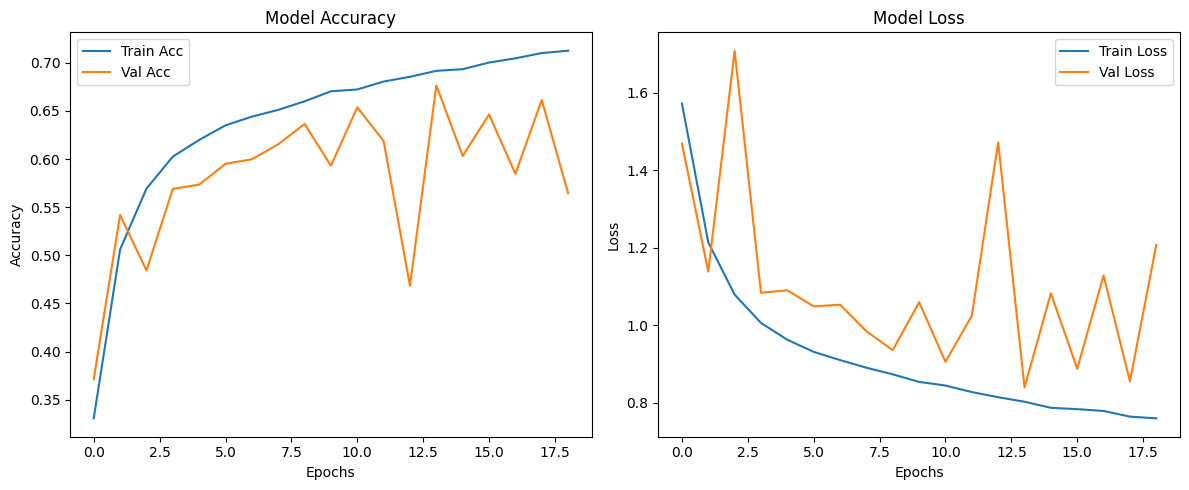

In [5]:
# Plot accuracy and loss
plt.figure(figsize=(12, 5))

# 1.Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# 2.Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()

In [6]:
# Get class indices to labels mapping
class_indices = val_generator.class_indices
idx_to_class = {v: k for k, v in class_indices.items()}

# Reset generator for fresh prediction
val_generator.reset()

# Predict class probabilities
y_probs = model.predict(val_generator, verbose=1)

# Get predicted and true labels
y_pred = np.argmax(y_probs, axis=1)
y_true = val_generator.classes

193/193 [==============================] - 25s 125ms/step


## Print classification metrics


In [7]:
report = classification_report(
    y_true, y_pred, target_names=idx_to_class.values())
print("Classification Report:\n")
print(report)

Classification Report:

              precision    recall  f1-score   support

       happy       0.89      0.77      0.83      1774
     neutral       0.56      0.64      0.60      1233
         sad       0.54      0.58      0.56      1247
    stressed       0.58      0.65      0.61      1069
    surprise       0.89      0.71      0.79       831

    accuracy                           0.68      6154
   macro avg       0.69      0.67      0.68      6154
weighted avg       0.70      0.68      0.68      6154



## Compute and plot confusion matrix


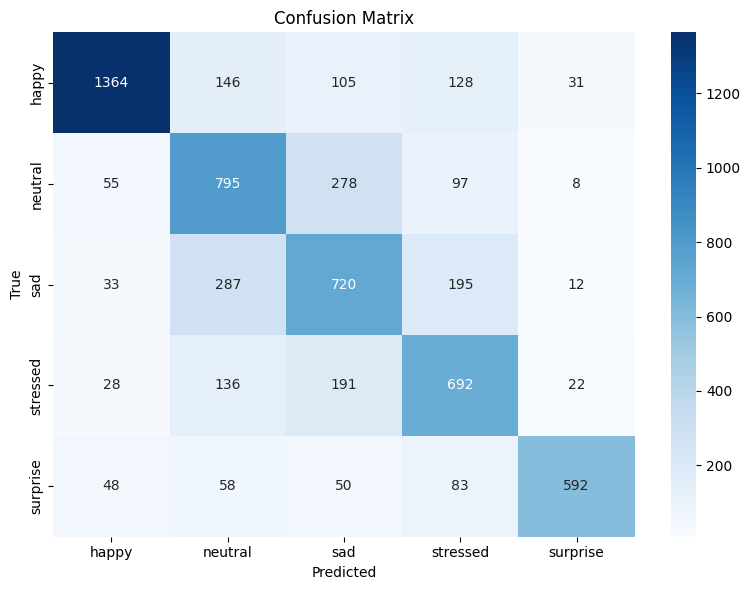

In [ ]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=idx_to_class.values(),
            yticklabels=idx_to_class.values())
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

## Real-time inference using webcam + Haar Cascade + OpenCV


This is one of the examples I provide to check whether the model is working in detecting real time facial emotions.


[INFO] Starting webcam...


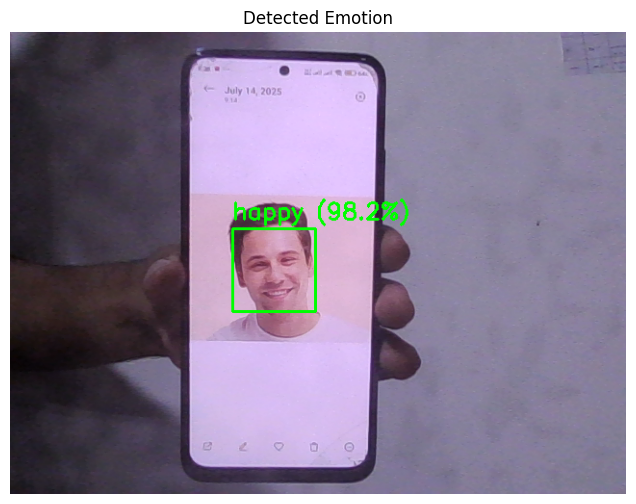

In [11]:
# Load model and face detector
model = load_model('../../models/FC211012_Azeem/emotion_detection_model.h5')
face_cascade = cv2.CascadeClassifier(
    cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
emotion_labels = ['happy', 'neutral', 'sad', 'surprise', 'stressed']

# Confidence threshold
CONFIDENCE_THRESHOLD = 0.7

# Start webcam
cap = cv2.VideoCapture(0)
print("[INFO] Starting webcam...")

ret, frame = cap.read()
if not ret:
    print("[ERROR] Unable to read from webcam.")
    cap.release()
else:
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(
        gray, scaleFactor=1.3, minNeighbors=5)

    for (x, y, w, h) in faces:
        roi_gray = gray[y:y+h, x:x+w]
        roi = cv2.resize(roi_gray, (48, 48)) / 255.0
        roi = np.expand_dims(roi, axis=(0, -1))

        preds = model.predict(roi, verbose=0)
        confidence = np.max(preds)
        label = emotion_labels[np.argmax(preds)]

        if confidence > CONFIDENCE_THRESHOLD:
            text = f"{label} ({confidence*100:.1f}%)"
            color = (0, 255, 0)
        else:
            text = "Uncertain"
            color = (0, 0, 255)

        # Draw rectangle and label
        cv2.rectangle(frame, (x, y), (x+w, y+h), color, 2)
        cv2.putText(frame, text, (x, y - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2)

    # Display using matplotlib
    plt.figure(figsize=(8, 6))
    plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title("Detected Emotion")
    plt.show()

cap.release()